In [1]:
from python_graphql_client import GraphqlClient
import pandas as pd
from datetime import datetime
import matplotlib

In [2]:
def client():
    return GraphqlClient(endpoint="https://api.thegraph.com/subgraphs/name/token-terminal-subgraphs/tornado-cash-v1-gnosis-chain")

def query(event, skip, timestamp):
    return """
    {
      """+event+"""(first: 1000, orderBy: blockTimestamp, skip: """+ str(skip)+""",
      where: {blockTimestamp_gt: """+ str(timestamp) +"""}) {
        id
        blockTimestamp
      }

    }
"""

In [3]:
def getPoolEvents(event, debug=False):
    timestamp=0
    poolEvents=0
    
    while(True):
        skip=0
        poolEventsTs=0
        while(skip <= 5000):
            querys = query(event, skip, timestamp)
            try:
                tgdata_raw = client().execute(query=querys)['data'][event]
                if debug : print(skip, timestamp, len(tgdata_raw))
            except:
                print(client().execute(query=querys))
                break
            tgdata = pd.DataFrame.from_dict(tgdata_raw)
            if type(poolEventsTs) is int : poolEventsTs = tgdata
            else : poolEventsTs = pd.concat([poolEventsTs,tgdata], ignore_index=True)

            if tgdata.shape[0] < 1000: break
            skip = skip + 1000
        if type(poolEvents) is int :  poolEvents = poolEventsTs 
        else :  poolEvents = pd.concat([poolEvents,poolEventsTs], ignore_index=True)

        if poolEventsTs.shape[0] < 6000: break
        timestamp = str(int(poolEventsTs['blockTimestamp'].iloc[-1]) -1)

    return poolEvents

poolEventsList =[]
for size in ['100','1000','10000','100000']:
    deposits = getPoolEvents(f'xdai{size}V1DepositV1Es').drop_duplicates()
    deposits['type'] = 'D'
    withdrawls = getPoolEvents(f'xdai{size}V1WithdrawalV1Es').drop_duplicates()
    withdrawls['type'] = 'W'
    combined = pd.concat([deposits, withdrawls])
    combined['amount'] = size
    combined['currency'] = 'xdai'
    poolEventsList.append(combined)

poolEvents = pd.concat(poolEventsList)

data grouping

In [4]:
poolEvents['date']= pd.to_datetime(poolEvents['blockTimestamp'], unit='s').dt.date

In [5]:
dailyPoolEventsList = []
for date, df in poolEvents.groupby('date'):
    df['type'] = df['currency'] +'-'+ df['amount'] +'-'+ df['type']
    dayEvents = df.groupby('type')['id'].count().rename(date)
    dailyPoolEventsList.append(dayEvents)
dailyPoolEvents = pd.concat(dailyPoolEventsList, axis=1).sort_values(by='type').fillna(0).transpose()
cumPoolEvents = dailyPoolEvents.cumsum()
cumPoolEvents.to_json('daily-events-gnosis.json')

In [6]:
import pandas as pd
eventDf = pd.read_json('daily-events-gnosis.json')

<AxesSubplot:>

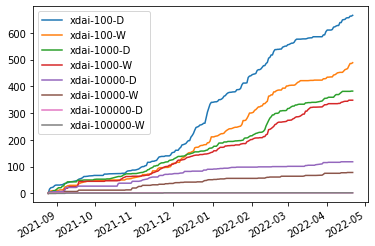

In [8]:
eventDf.plot()